# TO MERGE with make subcubes city 

City cube processing template
Download characteristics (collections) from SentinelHub from given geometry, process data and save results to database

In [27]:
%matplotlib inline

import numpy as np
import fiona
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import rasterio as rio
import IPython.display
import time  
import datetime
from contextlib import redirect_stdout
from src import utils

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    BBoxSplitter,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    SentinelHubDownloadClient,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    os_utils,
    Geometry
)

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")

## Get geometry from city code
TODO
- [ ]  handle geometries that are too large

In [ ]:
# read in the city polygons
INPUT_FILE_city = "./../../../s3/data/d001_administration/urban_audit_city_2021/URAU_RG_100K_2021_3035_CITIES/URAU_RG_100K_2021_3035_CITIES.shp"
geo_json_city = gpd.read_file(INPUT_FILE_city)
gdf_city = gpd.GeoDataFrame(geo_json_city, crs="EPSG:3035")
# compute bounding boxes
gdf = pd.concat([gdf_city, gdf_city.bounds], axis=1)
row = gdf[gdf.URAU_NAME == 'Gent']

In [102]:
#------------------------------------------
geometry_gdf = row.geometry # input argument
bbox_coords = row.minx, row.miny, row.maxx, row.maxy # input argument (or compute from geometry)
#------------------------------------------
geometry = Geometry(geometry=geometry_gdf.item(), crs=CRS('3035').pyproj_crs())
bbox = BBox(bbox=bbox_coords, crs=CRS('3035').pyproj_crs())
bbox_size = bbox_to_dimensions(bbox, resolution=10)

In [ ]:
if(bbox_subsize_b == 1 ): # bbox is small enough
    request = sentinelhub_stat_request(evalscript, geometry_b, bbox_b, bbox_size_b, config)
    try:
        data = request.get_data()[0]
        # do something with the data
        print(data)
    except:
        logger.info("an error occurred")
        print(row.URAU_CODE)
else: # need to split bbox in smaller bboxes
    logger.info(f"Splitting bounding box in {(bbox_subsize_b,bbox_subsize_b)} subgrid")
    bbox_split = BBoxSplitter([geometry_b], CRS('3035').pyproj_crs(), bbox_subsize_b, reduce_bbox_sizes=True)
    # create a list of requests
    bbox_list = bbox_split.get_bbox_list()
    geometry_list = [Geometry(geometry=utils.split_geometry(geometry_b, bbox), crs=CRS('3035').pyproj_crs()) for bbox in bbox_list]
    sh_requests = [sentinelhub_stat_request(evalscript, geometry, subbbox, bbox_to_dimensions(subbbox, resolution=10), config) for (geometry,subbbox) in list(zip(geometry_list,bbox_list))]
    i = 1
    error=False
    list_data = []
    for req in sh_requests:
        try:
        data = req.get_data()[0]
        # do something with the data
        list_data.append(data)
        i = i+1
        except:
            logger.info("an error occurred")
            print(row.URAU_CODE)
            error=True
    if(~error):
        # finalize process
        print(list_data)

## Collections

In [91]:
# URAU Cities
collection_id_city = "20774d38-7b2e-43e9-b574-66fa2954da1c"
collection_name_city = "urban_audit_2021_city"
data_collection_city = DataCollection.define_byoc(collection_id_city, name=collection_name_city)
# Urban atlas
collection_id_UA = "55c49191-4afa-4384-956e-e9b746f259f3"
collection_name_UA = "UrbanAtlas2018_10m_raster_2"
data_collection_UA = DataCollection.define_byoc(collection_id_UA, name=collection_name_UA)
# population density
# copy CollectionId from FAIRiCube catalog https://catalog.fairicube.eu/
collection_id_popdens = "b468089b-2627-4787-b984-89c10434f6c6"
collection_name_popdens = "Population_density"
# define collection
data_collection_popdens = DataCollection.define_byoc(collection_id_popdens, name=collection_name_popdens)
data_collection_popdens

<DataCollection.Population_density: DataCollectionDefinition(
  api_id: byoc-b468089b-2627-4787-b984-89c10434f6c6
  catalog_id: byoc-b468089b-2627-4787-b984-89c10434f6c6
  wfs_id: byoc-b468089b-2627-4787-b984-89c10434f6c6
  collection_type: BYOC
  collection_id: b468089b-2627-4787-b984-89c10434f6c6
  is_timeless: False
  has_cloud_coverage: False
)>

## Prepare request
Define evalscript and an helper function to get the SentinelHub requests

In [113]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [
            {
                datasource: "pop_dens",
                bands: ["populationDensity"]
            },
            {
                datasource: "UA",
                bands: ["B1"]
            }],
            output: {
                bands: 2,
                sampleType: "UINT16" // raster format will be UINT16
            }
        };
    }

    function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
        var sample_ua = samples.UA[0]
        var sample_pop_dens = samples.pop_dens[0]
        return [sample_pop_dens.populationDensity, sample_ua.B1];

      
    }
"""
input_data = [
        SentinelHubRequest.input_data(
            data_collection=DataCollection.Population_density,
            identifier="pop_dens",
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.UrbanAtlas2018_10m_raster_2,
            identifier="UA",
        )
    ]
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=input_data,
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=bbox_size,
    geometry = geometry,
    config=config,
    )
# data = request.get_data()[0]

## Bounding box is small enough

Image type: uint16


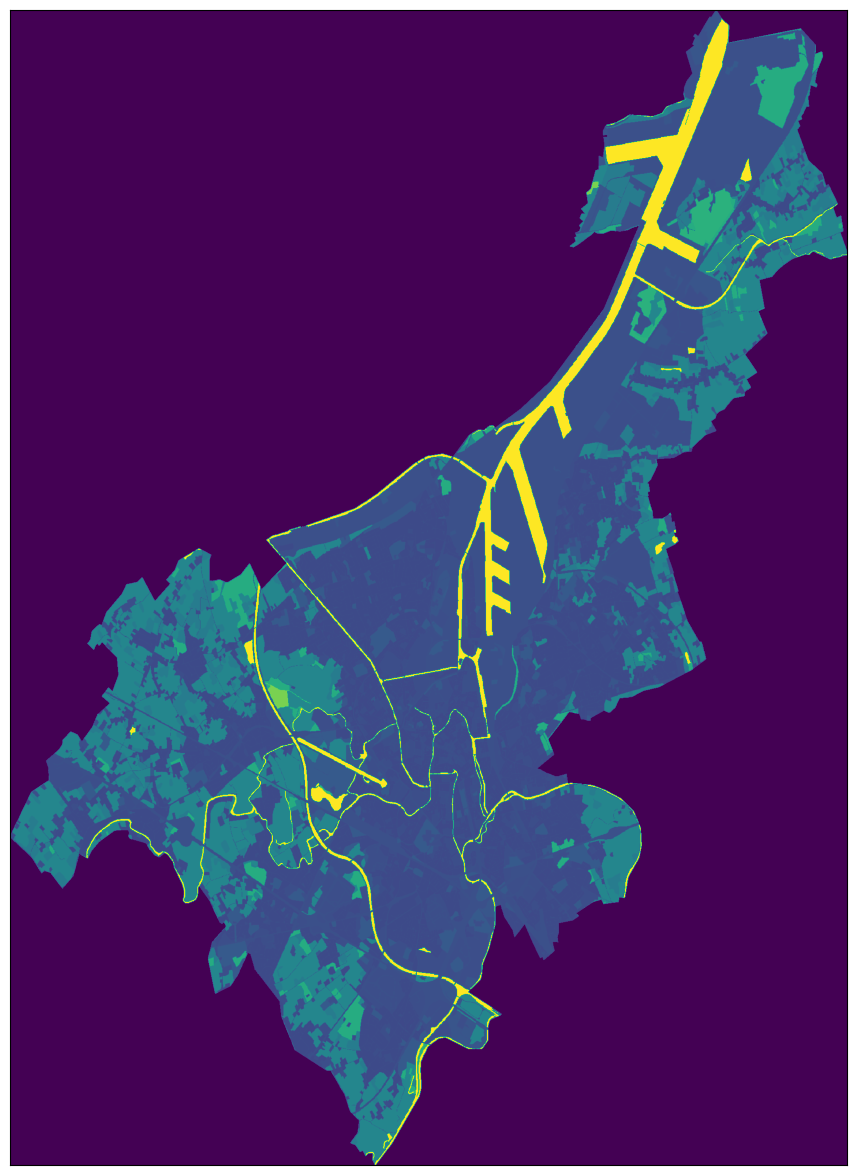

In [114]:
images = request.get_data()[0]
print(f"Image type: {images.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(images[:,:,1],factor=3.5 / 255)

## Bbox too large, split in subboxes

In [ ]:
if(bbox_subsize_b == 1 ): # bbox is small enough
    request = sentinelhub_stat_request(evalscript, geometry_b, bbox_b, bbox_size_b, config)
    try:
        data = request.get_data()[0]
        # do something with the data
        print(data)
    except:
        logger.info("an error occurred")
        print(row.URAU_CODE)
else: # need to split bbox in smaller bboxes
    logger.info(f"Splitting bounding box in {(bbox_subsize_b,bbox_subsize_b)} subgrid")
    bbox_split = BBoxSplitter([geometry_b], CRS('3035').pyproj_crs(), bbox_subsize_b, reduce_bbox_sizes=True)
    # create a list of requests
    bbox_list = bbox_split.get_bbox_list()
    geometry_list = [Geometry(geometry=utils.split_geometry(geometry_b, bbox), crs=CRS('3035').pyproj_crs()) for bbox in bbox_list]
    sh_requests = [sentinelhub_stat_request(evalscript, geometry, subbbox, bbox_to_dimensions(subbbox, resolution=10), config) for (geometry,subbbox) in list(zip(geometry_list,bbox_list))]
    i = 1
    error=False
    list_data = []
    for req in sh_requests:
        try:
        data = req.get_data()[0]
        # do something with the data
        list_data.append(data)
        i = i+1
        except:
            logger.info("an error occurred")
            print(row.URAU_CODE)
            error=True
    if(~error):
        # finalize process
        print(list_data)